In [ ]:
from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import math
from dataclasses import dataclass
from matplotlib import pyplot as plt
import time
import os
from ipywidgets import Output
from tqdm.notebook import trange, tqdm

# Pour torch si vous avez un GPU
# device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU

In [ ]:
# Environement potentielement testé
from environnement.environnement import Environnement as env # mother class
from environnement.environnement1 import Environnement1 as env1
from environnement.environnement2Str import Environnement2 as env2Str
from environnement.environnement3Str import Environnement3 as env3Str
from environnement.environnement6Str import Environnement6 as env6Str
from environnement.small_loop import small_loop

# model machine learning
from model.DeepNN import *
from model.Tokenizer import *
from model.RNN import *
from model.CustomDataSet import CustomDataSet, CustomDataSetRNN
from outil import *
from inter.interactions import Interaction
from inter.simpleInteraction import simpleInteraction as inter

In [ ]:
class AgentLSTM:
    def __init__(self, model, all_outcomes, all_actions, tokenizer, valence:dict,
                optimizer, gap_train=11, gap_test=11, loss_func=None):
        """ 
        Création de l'agent.
        
        - self._action : action précédente
        - self._predicted_outcome : prédiction de l'outcome précédent
        """
        self._action = None
        self._predicted_outcome = None
        self._model = model
        self.optimizer = optimizer
        self._loss_func = loss_func
        self._tokenizer:SimpleTokenizerV1 = tokenizer
        self._all_outcomes = all_outcomes
        self._all_actions = all_actions
        self._history_act = []
        self._history_fb = []
        self._valence = valence
        self._gap_train = gap_train
        self._gap_test = gap_test
        self._boredom = 0

    def fit(self, actions:list, outcomes:list, nb_epoch:int=25, context_lenght=5, validate_loader=None):
        """
        Fonction d'entrainement de l'agent 
        Avec data set custom, le model prends en inputs plusieurs données
        """
        
        if len(actions) + len(outcomes) < context_lenght:
            raise Exception("Not enough data to train model")
        
        if isinstance(self._model, torch.nn.Module):
            data_loarder = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=context_lenght, dim_out=2, tokenizer=self._tokenizer)

            data_loader = torch.utils.data.DataLoader(
                data_loarder, batch_size=32, shuffle=True)
            for e in range(nb_epoch):
                for x,t in data_loader:
                    bs = t.shape[0]
                    h = torch.zeros(self._model.num_layers, bs, self._model.hidden_size, device=device)
                    cell = torch.zeros(self._model.num_layers, bs, self._model.hidden_size, device=device)

                    pred, h, cell = self._model(x, h, cell)

                    loss = self._loss_func(pred[:, -1, :], t)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        else: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            self._model.fit(action, outcome)
            pass

    def predict(self, action, gap=5):
        if len(self._history_act) + len(self._history_fb) < gap:
            raise Exception("Not enough data to train model")
        x = []
        for i in range(len(self._history_act) - gap, len(self._history_act)):
            x.append(self._history_act[i])
            x.append(self._history_fb[i])
        x.append(action)
        action = self._tokenizer.encode(x)

        action = torch.tensor([action], dtype=torch.int).to(device)

        h = torch.zeros(self._model.num_layers, 1, self._model.hidden_size, device=device)
        cell = torch.zeros(self._model.num_layers, 1, self._model.hidden_size, device=device)
        
        with torch.no_grad():  # Pas de calcul de gradients en mode prédiction
            pred, _, _ = self._model(action, h, cell)

        pred_feedback = torch.argmax(pred[:, -1, :]).item()
        pred_feedback = self._tokenizer.decode(pred_feedback)
        
        return pred_feedback
    
    def recursif_expective_valance(self, seq:list, max_depth:int, seuil:float=0.2, proba:float = 1,
                                    seq_predi:list = []):
        """
        """
        if max_depth == 0:
            return {}
        max_depth -= 1

        if proba < seuil:
            return {}
        
        self._model.eval()
        exceptive_valance = {}
        for act in self._all_actions:
            new_seq = seq_predi + [act]
            seq_to_predict = seq + [self._tokenizer.encode(act)]
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)

            hidden = torch.zeros(self._model.num_layers, 1, self._model.hidden_size, device=device)
            memory = torch.zeros(self._model.num_layers, 1, self._model.hidden_size, device=device)

            x, _, _ = self._model(seq_to_predict, hidden, memory)
            x = x[0, -1, :]
            # Transforme x into list proba
            probs = torch.nn.functional.softmax(x, dim=0).tolist()
            # for each outcomes we want proba with act
            for i, out in enumerate(self._all_outcomes):
                tmp_new_seq = new_seq + [out]
                tmp_proba = probs[i] * proba
                if tmp_proba < seuil:
                    continue
                tempo = float(np.round(self._valence[inter(act, out)] * tmp_proba, decimals=4))
                # input(f'seq {seq_predi} act {act} out {out} proba {tmp_proba} valance {valance[(act, out)]} tempo {tempo}')
                exceptive_valance.update(
                    self.recursif_expective_valance(seq=seq[2:] + [self._tokenizer.encode(act), self._tokenizer.encode(out)],
                                                max_depth=max_depth, seuil=seuil, 
                                                proba=tmp_proba, seq_predi=tmp_new_seq.copy())
                )
                exceptive_valance[str(tmp_new_seq)] = tempo
        return exceptive_valance
        
    def decide(self):
        x = []
        for i in range(-self._gap_test//2, 0, 1):
            x.append(self._history_act[i])
            x.append(self._history_fb[i])
        seq = self._tokenizer.encode(x)
        res = self.recursif_expective_valance(seq=seq, max_depth=4, seuil=0.2)
        top_5 = sorted(res.items(), key=lambda x: x[1], reverse=True)[:5]
        # print(f"Top 5 of sequences with the best expected valance for {x}")
        # for top in top_5:
        #     print(f"Sequence: {top[0]} Expected valance: {top[1]}")
        
        # print(f"Action choisie : {eval(top_5[0][0])[0]}")
        return eval(top_5[0][0])[0]

    # Modifier
    def action(self, outcome, fit=True, decide=True, validate_loader=None, force_fit=False):
        """ 
        Fonction qui choisit l'action a faire en fonction de la dernière \
        intéraction avec l'environnement. \n
        C'est ici que nous allons implémenter un mécanisme de ML \
        pour choisir la prochaine action.

        :param: **outcome** feedback de la dernière intéraction avec l'environnement

        :return: **action** action à effectuer
        """
        self._boredom += 1
        description = None
        if self._action is not None:
            self._history_fb.append(outcome)
            description = f"Action: {self._action}, Prediction: {self._predicted_outcome}, Outcome: {outcome}, \033[0;31m Satisfaction: {self._predicted_outcome == outcome} \033[0m"
            if len(self._history_act) + len(self._history_fb) > self._gap_train:
                # and self._predicted_outcome != outcome
                if fit and self._predicted_outcome != outcome:
                    self.fit(self._history_act, self._history_fb, validate_loader=validate_loader,
                            nb_epoch=50, context_lenght=self._gap_train)
                    self._boredom = 0
                
            if decide and len(self._history_act) + len(self._history_fb) > self._gap_test:
                self._action = self.decide()
            else :
                self._action = str(np.random.choice(self._all_actions))
                
            if len(self._history_act) + len(self._history_fb) > self._gap_test:
                self._predicted_outcome = self.predict(self._action, gap=self._gap_test)
            
            self._history_act.append(self._action)
        else:
            self._action = self._all_actions[0]
            self._history_act.append(self._action)            
            description = f"Action de base : {self._action} Prediction: {self._predicted_outcome}"
        
        return self._action, self._predicted_outcome, description

Output()

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

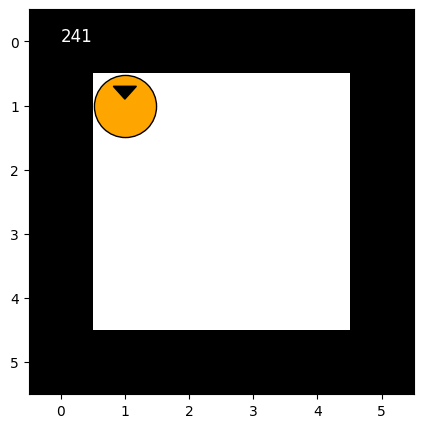

In [ ]:
env_test2 = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

model_ML = LSTM(hidden_size=128, num_emb=len(env_test2.get_outcomes() + env_test2.get_actions()),
                num_layers=2, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

valence = {
    inter('forward', 'empty') : 1,
    inter('forward', 'wall') : -10,
    inter('turn_left', 'empty') : -7,
    inter('turn_left', 'wall') : -80,
    inter('turn_right', 'empty') : -7,
    inter('turn_right', 'wall') : -80,
    inter('feel_front', 'wall') : -5,
    inter('feel_front', 'empty') : -5,
}

agent_test2 = AgentLSTM(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    valence=valence,
    tokenizer=tokenizer,
    optimizer=optimizer,
    loss_func=loss_func,
    gap_train=21,
    gap_test=21)

history_good = []
pourcent_by_10 = []
outcome = None

out = Output()
display(out)

for i in tqdm(range(100)):
    # start_time = time.time()
    action, predi, description = agent_test2.action(outcome, fit=False, decide=False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    # env_test2.display_world(out)
    env_test2.save_world()
raise Exception("Fin du training")
    

In [ ]:
action, predi, description = agent_test2.action(outcome, fit=True, decide=True, force_fit=True)
outcome = env_test2.outcome(action)
history_good.append(outcome == predi)
pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
env_test2.save_world()

for i in tqdm(range(1000)):
    # print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    start_time = time.time()
    action, predi, description = agent_test2.action(outcome, fit=True, decide=True)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    # env_test2.display_world(out)
    env_test2.save_world()

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
raise Exception("Fin de l'execution")
out = Output()
out_id = None

Exception: Fin de l'execution

In [ ]:
# env_test2 = small_loop(x=1, y=1, world=np.array([
#                 [1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 1, 1, 0, 1],
#                 [1, 0, 1, 0, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1],
#             ]))
env_test2 = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1],
            ]))


agent_test2._history_act = []
agent_test2._history_fb = []
agent_test2._action = None

# for i in tqdm(range(50)):
#     action, predi, description = agent_test2.action(outcome, fit=True, decide=False)
#     outcome = env_test2.outcome(action)
#     env_test2.save_world()

for i in tqdm(range(100)):
    action, predi, description = agent_test2.action(outcome, fit=True, decide=True)
    outcome = env_test2.outcome(action)
    env_test2.save_world()

In [ ]:
display(out)

In [ ]:
outcome = env_test2.outcome('forward')
env_test2.display_world(out)

In [ ]:
outcome = env_test2.outcome('turn_left')
env_test2.display_world(out)

In [ ]:
outcome = env_test2.outcome('turn_right')
env_test2.display_world(out)

In [ ]:
outcome = env_test2.outcome('feel_front')
env_test2.display_world(out)

In [ ]:
raise Exception("Fin de l'execution")

In [ ]:

for i in range(100):
    env_test2.display_world(out)
    action, predi = agent_test2.action(outcome, decide=True)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)

In [ ]:
def show_proba_from_seq(_seg):
    seq = tokenizer.encode(_seg)
    seq = torch.tensor([seq], dtype=torch.int).to(device)
    h = torch.zeros(agent_test2._model.num_layers, 1, agent_test2._model.hidden_size, device=device)
    cell = torch.zeros(agent_test2._model.num_layers, 1, agent_test2._model.hidden_size, device=device)
    predi, _, _ =  agent_test2._model(seq, h, cell)
    predi = predi[0, -1, :]
    prob = torch.nn.functional.softmax(predi, dim=0)
    deocde = tokenizer.decode(torch.argmax(predi, dim=0).item())
    print(f"Prédiction de la séquence {_seg} :  probabilité {prob.tolist()}, decode {deocde}")

print("porba si on avance")
show_proba_from_seq(['forward', 'empty', 'forward'])
show_proba_from_seq(['forward', 'wall', 'forward'])
show_proba_from_seq(['turn_left', 'empty', 'forward'])
show_proba_from_seq(['turn_right', 'empty', 'forward'])
show_proba_from_seq(['feel_front', 'empty', 'forward'])
show_proba_from_seq(['feel_front', 'wall', 'forward'])

print("porba si on turn left")
show_proba_from_seq(['forward', 'empty', 'turn_left'])
show_proba_from_seq(['forward', 'wall', 'turn_left'])
show_proba_from_seq(['turn_left', 'empty', 'turn_left'])
show_proba_from_seq(['turn_right', 'empty', 'turn_left'])
show_proba_from_seq(['feel_front', 'empty', 'turn_left'])
show_proba_from_seq(['feel_front', 'wall', 'turn_left'])

print("porba si on turn right")
show_proba_from_seq(['forward', 'empty', 'turn_right'])
show_proba_from_seq(['forward', 'wall', 'turn_right'])
show_proba_from_seq(['turn_left', 'empty', 'turn_right'])
show_proba_from_seq(['turn_right', 'empty', 'turn_right'])
show_proba_from_seq(['feel_front', 'empty', 'turn_right'])
show_proba_from_seq(['feel_front', 'wall', 'turn_right'])

print("porba si on feel front")
show_proba_from_seq(['forward', 'empty', 'feel_front'])
show_proba_from_seq(['forward', 'wall', 'feel_front'])
show_proba_from_seq(['turn_left', 'empty', 'feel_front'])
show_proba_from_seq(['turn_right', 'empty', 'feel_front'])
show_proba_from_seq(['feel_front', 'empty', 'feel_front'])
show_proba_from_seq(['feel_front', 'wall', 'feel_front'])

def count_pattern(lst, pattern):
    return sum(1 for i in range(len(lst) - len(pattern) + 1) if lst[i:i+len(pattern)] == pattern)

list_act_out = []
for act, out in zip(agent_test2._history_act, agent_test2._history_fb):
    list_act_out.append(act)
    list_act_out.append(out)

print("count si on avance")
print(f"pattern 'forward', 'empty', 'forward', 'empty' présent : {count_pattern(list_act_out, ['forward', 'empty', 'forward', 'empty'])}")
print(f"pattern 'forward', 'empty', 'forward', 'wall' présent : {count_pattern(list_act_out, ['forward', 'empty', 'forward', 'wall'])}")
print(f"pattern 'forward', 'wall', 'forward', 'empty' présent : {count_pattern(list_act_out, ['forward', 'wall', 'forward', 'empty'])}")
print(f"pattern 'forward', 'wall', 'forward', 'wall' présent : {count_pattern(list_act_out, ['forward', 'wall', 'forward', 'wall'])}")
print(f"pattern 'turn_left', 'empty', 'forward', 'empty' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'forward', 'empty'])}")
print(f"pattern 'turn_left', 'empty', 'forward', 'wall' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'forward', 'wall'])}")
print(f"pattern 'turn_right', 'empty', 'forward', 'empty' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'forward', 'empty'])}")
print(f"pattern 'turn_right', 'empty', 'forward', 'wall' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'forward', 'wall'])}")
print(f"pattern 'feel_front', 'empty', 'forward', 'empty' présent : {count_pattern(list_act_out, ['feel_front', 'empty', 'forward', 'empty'])}")
print(f"pattern 'feel_front', 'empty', 'forward', 'wall' présent : {count_pattern(list_act_out, ['feel_front', 'empty', 'forward', 'wall'])}")
print(f"pattern 'feel_front', 'wall', 'forward', 'empty' présent : {count_pattern(list_act_out, ['feel_front', 'wall', 'forward', 'empty'])}")
print(f"pattern 'feel_front', 'wall', 'forward', 'wall' présent : {count_pattern(list_act_out, ['feel_front', 'wall', 'forward', 'wall'])}")

print("count si on feel_front")
print(f"pattern 'forward', 'empty', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['forward', 'empty', 'feel_front', 'empty'])}")
print(f"pattern 'forward', 'empty', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['forward', 'empty', 'feel_front', 'wall'])}")
print(f"pattern 'forward', 'wall', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['forward', 'wall', 'feel_front', 'empty'])}")
print(f"pattern 'forward', 'wall', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['forward', 'wall', 'feel_front', 'wall'])}")
print(f"pattern 'turn_left', 'empty', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'feel_front', 'empty'])}")
print(f"pattern 'turn_left', 'empty', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'feel_front', 'wall'])}")
print(f"pattern 'turn_right', 'empty', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'feel_front', 'empty'])}")
print(f"pattern 'turn_right', 'empty', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'feel_front', 'wall'])}")
print(f"pattern 'feel_front', 'empty', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['feel_front', 'empty', 'feel_front', 'empty'])}")
print(f"pattern 'feel_front', 'empty', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['feel_front', 'empty', 'feel_front', 'wall'])}")
print(f"pattern 'feel_front', 'wall', 'feel_front', 'empty' présent : {count_pattern(list_act_out, ['feel_front', 'wall', 'feel_front', 'empty'])}")
print(f"pattern 'feel_front', 'wall', 'feel_front', 'wall' présent : {count_pattern(list_act_out, ['feel_front', 'wall', 'feel_front', 'wall'])}")

print("count si on turn_left turn_right")
print(f"pattern 'turn_left', 'empty', 'turn_left', 'empty' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'turn_left', 'empty'])}")
print(f"pattern 'turn_right', 'empty', 'turn_left', 'empty' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'turn_left', 'empty'])}")
print(f"pattern 'turn_right', 'empty', 'turn_right', 'empty' présent : {count_pattern(list_act_out, ['turn_right', 'empty', 'turn_right', 'empty'])}")
print(f"pattern 'turn_left', 'empty', 'turn_right', 'empty' présent : {count_pattern(list_act_out, ['turn_left', 'empty', 'turn_right', 'empty'])}")



In [ ]:
# See decision
x = []
for i in range(agent_test2._gap_test):
    x.append(agent_test2._history_act[-(agent_test2._gap_test -i)])
    x.append(agent_test2._history_fb[-(agent_test2._gap_test -i)])
    print(-(agent_test2._gap_test -i), i)
seq = agent_test2._tokenizer.encode(x)
res = agent_test2.recursif_expective_valance(seq=seq, max_depth=3, seuil=0.4)
top_5 = sorted(res.items(), key=lambda x: x[1], reverse=True)[:5]
print(f"Top 5 of sequences with the best expected valance for {x}")
for top in top_5:
    print(f"Sequence: {top[0]} Expected valance: {top[1]}")

print(f"Action choisie : {eval(top_5[0][0])[0]}")

print(f'size of history act {len(agent_test2._history_act)}')
print(f'size of history fb {len(agent_test2._history_fb)}')
print(f'gap {agent_test2._gap_test}')

print([i for i in zip(agent_test2._history_act, agent_test2._history_fb)])

In [ ]:
agent_test2._history_act.append('feel_front')
agent_test2._history_fb.append('empty')